In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [212]:
# Data Link : https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand

In [213]:
df = pd.read_csv(
    r"S:\Machine\seoul_bike_sharing_demand\SeoulBikeData.csv",
    encoding="latin1"
)

# Drop unwanted columns
df = df.drop(["Date", "Seasons", "Holiday"], axis=1)

# Rename columns ONLY ONCE
df.columns = [
    "bike_count",
    "hour",
    "temp",
    "humidity",
    "wind",
    "visibility",
    "dew_pt_temp",
    "solar_radiation",
    "rain",
    "snow",
    "function_day"
]

# Encode function_day
df["function_day"] = (df["function_day"] == "Yes").astype(int)

# Filter and drop hour
df = df[df["hour"] == 12]
df = df.drop(columns=["hour"])

In [214]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,solar_radiation,rain,snow,function_day
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


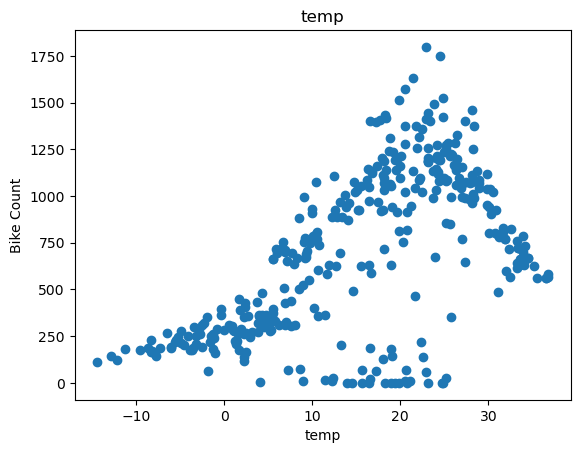

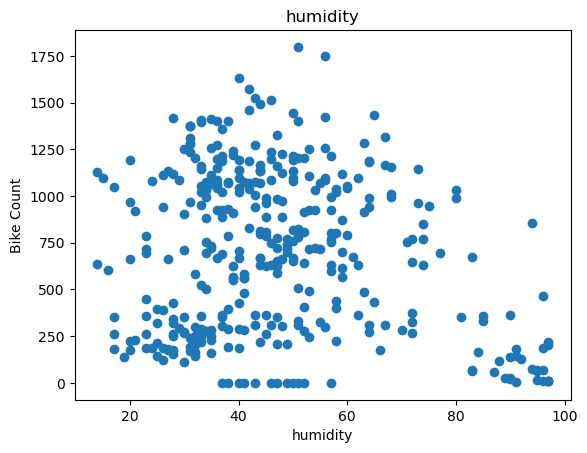

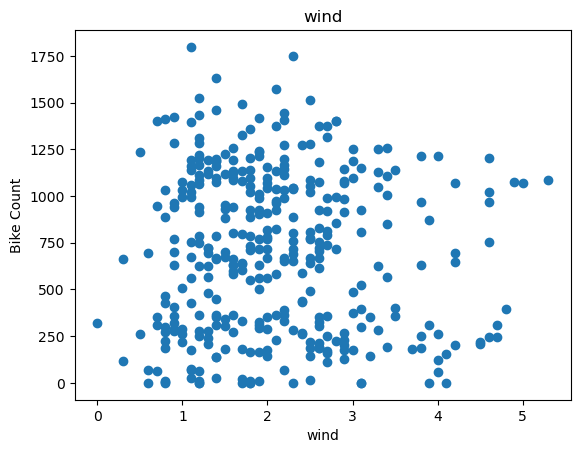

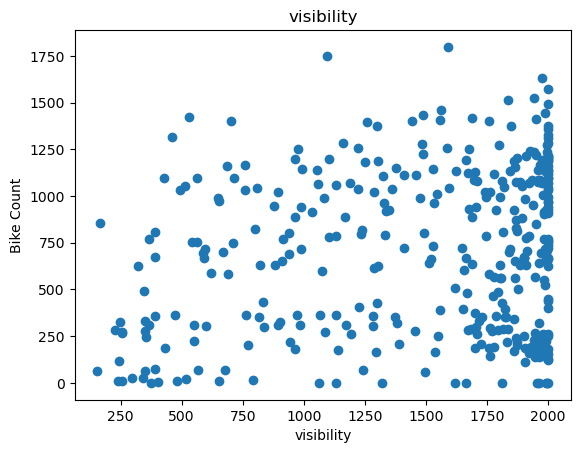

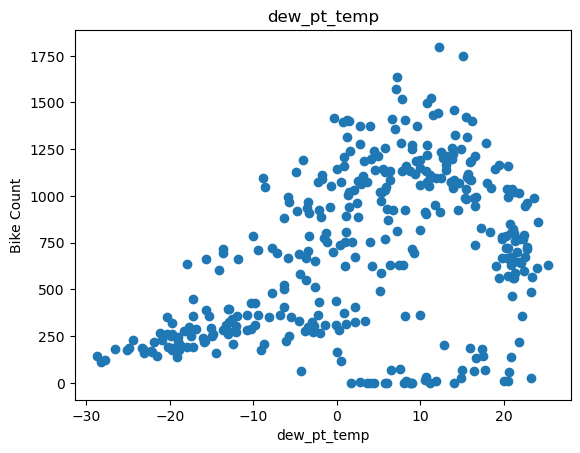

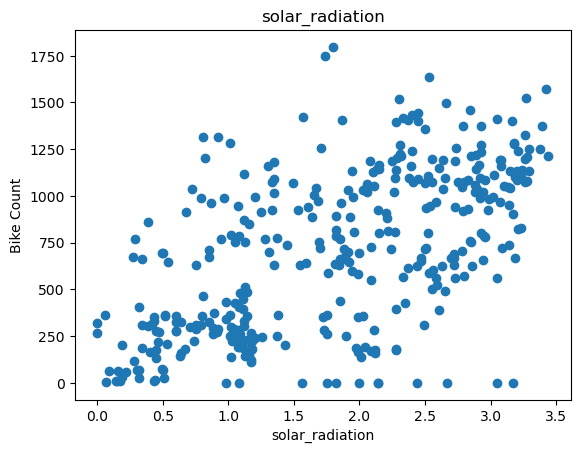

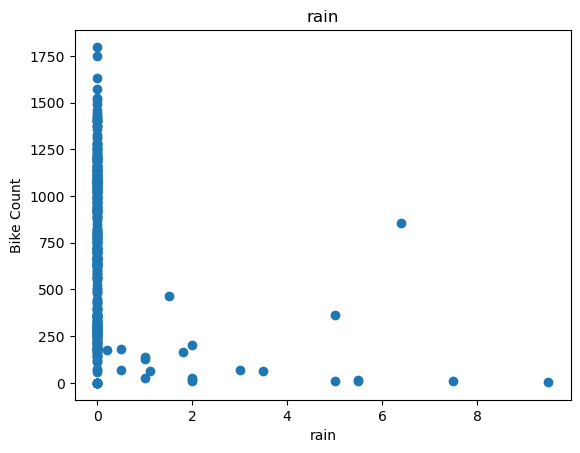

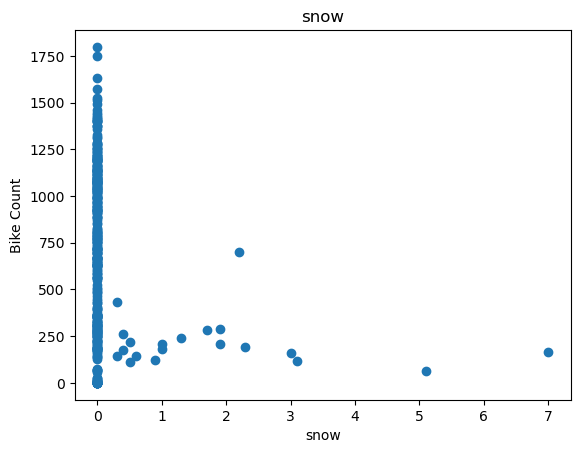

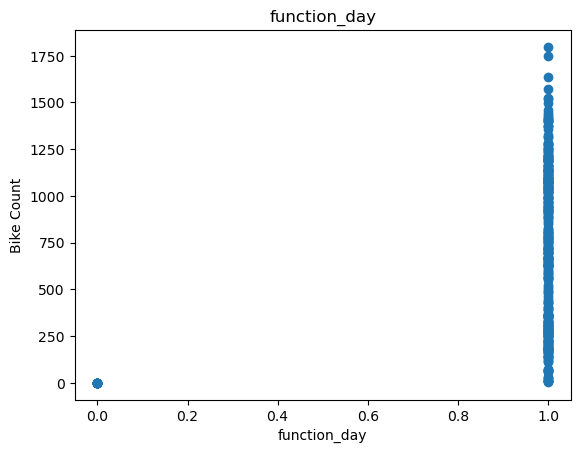

In [215]:
for label in df.columns[1:]:
    plt.scatter(df[label],df['bike_count'])
    plt.title(label)
    plt.xlabel(label)
    plt.ylabel('Bike Count')
    plt.show()

In [216]:
df = df.drop(["wind", "visibility", "function_day"], axis=1)

In [217]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,solar_radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


In [218]:
# Split Train , Test , validation

In [219]:
train,test,valid=np.split(df.sample(frac=1,random_state=42).reset_index(drop=True),[int(0.6*len(df)),int(0.8*len(df))])

C:\Users\Asus\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [220]:
# Function to extract features (X) and target (y) from a dataframe
def get_xy(dataframe, y_label, x_labels=None):
    
    # Create a deep copy of the dataframe to avoid modifying the original
    df = copy.deepcopy(dataframe)

    # If feature columns are NOT explicitly provided
    if x_labels is None:
        
        # Use all columns except the target column as features
        X = df[[col for col in df.columns if col != y_label]].values

    else:
        # If only one feature column is provided
        if len(x_labels) == 1:
            
            # Reshape to 2D array (required by ML models)
            X = df[x_labels[0]].values.reshape(-1, 1)
        
        # If multiple feature columns are provided
        else:
            X = df[x_labels].values

    # Extract target column and reshape to 2D
    y = df[y_label].values.reshape(-1, 1)

    # Combine X and y horizontally (useful for some workflows)
    data = np.hstack((X, y))

    # Return combined data, features, and target separately
    return data, X, y


In [221]:
temp,x_train,y_train=get_xy(train,'bike_count',x_labels=['temp'])
temp,x_valid,y_valid=get_xy(valid,'bike_count',x_labels=['temp'])
temp,x_test,y_test=get_xy(test,'bike_count',x_labels=['temp'])

In [222]:
temp_reg=LinearRegression()
temp_reg.fit(x_train,y_train)

LinearRegression()

In [223]:
# Print the learned coefficients (weights) and intercept (bias) of the trained regression model
print(temp_reg.coef_, temp_reg.intercept_)

[[21.75179095]] [375.94689703]


In [224]:
# Evaluate the regression model on test data
# Returns the R² (coefficient of determination) score
temp_reg.score(x_test,y_test)

0.3916506446071202

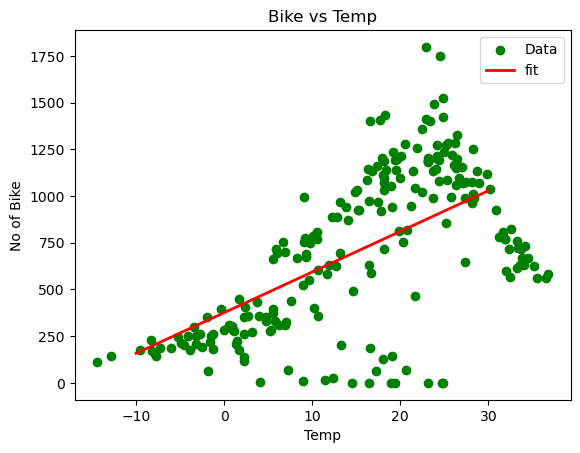

In [225]:
plt.scatter(x_train,y_train,label='Data',color='green')
x=tf.linspace(-10,30,70)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)),label='fit',color='red',linewidth=2)
plt.title('Bike vs Temp')
plt.xlabel('Temp')
plt.ylabel('No of Bike')
plt.legend()
plt.show()

In [226]:
# Multiple Linear Regression

In [227]:
all,x_train_all,y_train_all=get_xy(train,'bike_count',x_labels=df.columns[1:])
all,x_valid_all,y_valid_all=get_xy(valid,'bike_count',x_labels=df.columns[1:])
all,x_test_all,y_test_all=get_xy(test,'bike_count',x_labels=df.columns[1:])

In [228]:
all_reg=LinearRegression()
all_reg.fit(x_train_all,y_train_all)

LinearRegression()

In [229]:
all_reg.score(x_test_all,y_test_all)

0.510665886904438

In [230]:
from sklearn.metrics import mean_squared_error

# Predict on training and validation data
y_train_pred = all_reg.predict(x_train_all)
y_valid_pred = all_reg.predict(x_valid_all)

# Calculate Mean Squared Error
train_mse = mean_squared_error(y_train, y_train_pred)
valid_mse = mean_squared_error(y_valid, y_valid_pred)

# Print loss values
print("Train MSE:", train_mse)
print("Validation MSE:", valid_mse)

Train MSE: 95965.50798061452
Validation MSE: 105289.8915446056


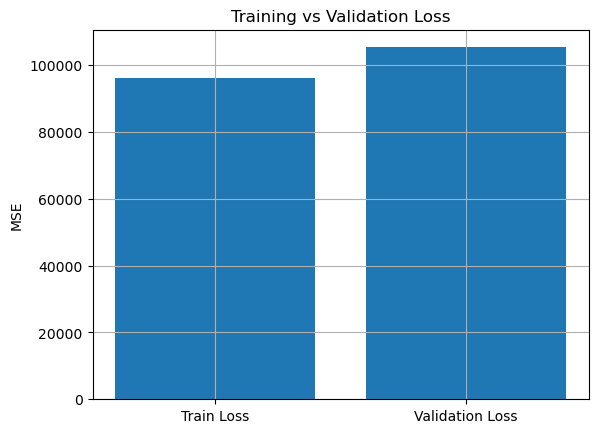

In [231]:
# Plot MSE comparison
plt.bar(['Train Loss', 'Validation Loss'], [train_mse, valid_mse])
plt.ylabel('MSE')
plt.title('Training vs Validation Loss')
plt.grid(True)
plt.show()

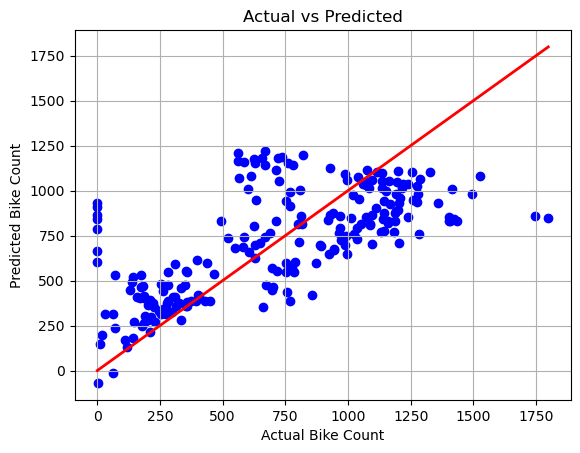

In [232]:
# Predict on training data
y_train_pred = all_reg.predict(x_train_all)

# Plot actual vs predicted values
plt.scatter(y_train_all, y_train_pred, color='blue')
plt.plot(
    [y_train_all.min(), y_train_all.max()],
    [y_train_all.min(), y_train_all.max()],
    color='red',
    linewidth=2
)

plt.xlabel('Actual Bike Count')
plt.ylabel('Predicted Bike Count')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

In [233]:
# Regression With Neural Network

In [234]:
temp_normal=tf.keras.layers.Normalization(input_shape=(1,),axis=None)
temp_normal.adapt(x_train.reshape(-1))

C:\Users\Asus\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [235]:
temp_nn_model=tf.keras.Sequential([tf.keras.layers.Dense(1),temp_normal])

In [236]:
# Compile the neural network model
# Adam optimizer is used with a learning rate of 0.1
# Mean Squared Error (MSE) is used as the loss for regression
temp_nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error'
)

In [237]:
# Function to plot training and validation loss
def plot_loss(history):
    
    # Plot training loss for each epoch
    plt.plot(history.history['loss'], label='train_loss')
    
    # Plot validation loss for each epoch
    plt.plot(history.history['val_loss'], label='val_loss')
    
    # Label the x-axis
    plt.xlabel('Epoch')
    
    # Label the y-axis (Mean Squared Error)
    plt.ylabel('MSE')
    
    # Display legend
    plt.legend()
    
    # Enable grid for better readability
    plt.grid(True)
    
    # Show the plot
    plt.show()


In [238]:
# Train the neural network model
history = temp_nn_model.fit(
    x_train,                 # Training features (keep 2D shape)
    y_train,                 # Training labels
    epochs=1000,              # Number of training epochs
    validation_data=(x_valid, y_valid),  # Validation dataset
    verbose=0                # Suppress training logs
)

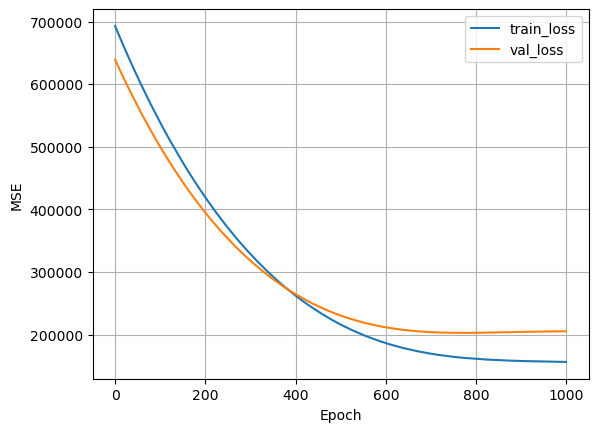

In [239]:
plot_loss(history)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


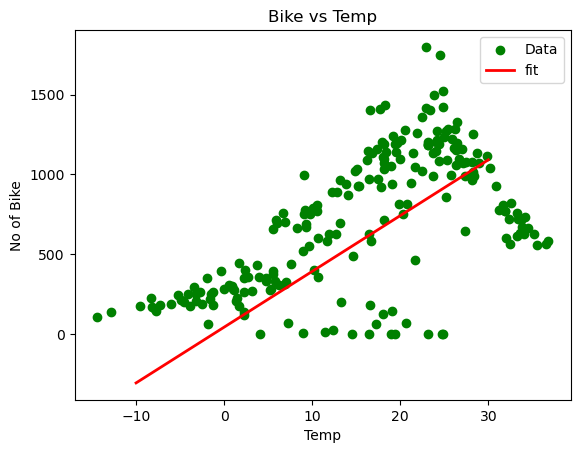

In [240]:
plt.scatter(x_train,y_train,label='Data',color='green')
x=tf.linspace(-10,30,70)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)),label='fit',color='red',linewidth=2)
plt.title('Bike vs Temp')
plt.xlabel('Temp')
plt.ylabel('No of Bike')
plt.legend()
plt.show()

In [241]:
# Neural Network

In [252]:
temp_normal=tf.keras.layers.Normalization(axis=-1)
temp_normal.adapt(x_train)

nn_model=tf.keras.Sequential(
    [temp_normal,
     tf.keras.layers.Dense(128,activation='relu'),
     tf.keras.layers.Dense(64,activation='relu'),
     tf.keras.layers.Dense(1)])

nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',metrics=['mae']
)

In [254]:
# Early stopping callback
# Stops training when validation loss does not improve for 20 consecutive epochs
# restore_best_weights=True loads the model weights from the epoch
# where validation loss was lowest
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

# Train the neural network model
history = nn_model.fit(
    x_train,                     # Training features
    y_train,                     # Training target values
    validation_data=(x_valid, y_valid),  # Validation dataset
    epochs=500,                  # Maximum number of training epochs
    callbacks=[early_stop],      # Apply early stopping
    verbose=0                    # Suppress training logs
)

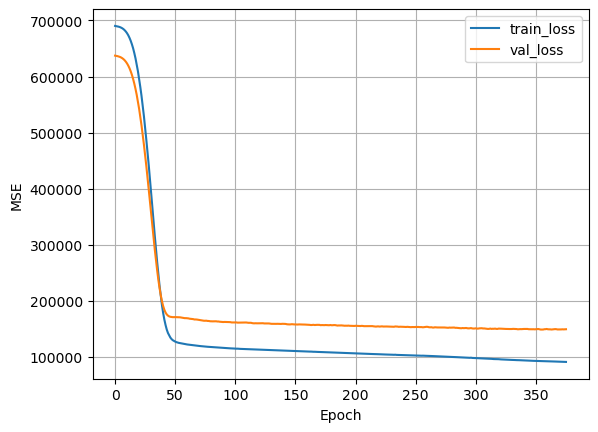

In [255]:
plot_loss(history)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


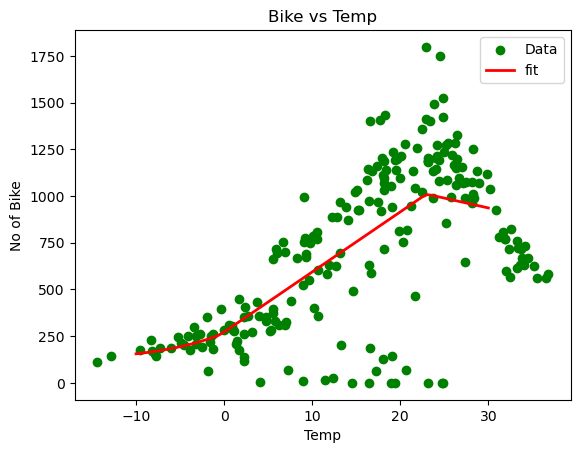

In [256]:
plt.scatter(x_train,y_train,label='Data',color='green')
x=tf.linspace(-10,30,70)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)),label='fit',color='red',linewidth=2)
plt.title('Bike vs Temp')
plt.xlabel('Temp')
plt.ylabel('No of Bike')
plt.legend()
plt.show()

In [257]:
from sklearn.metrics import r2_score

y_pred = nn_model.predict(x_valid).reshape(-1)
print("R²:", r2_score(y_valid, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
R²: 0.23885206879084264


In [272]:
all_normal=tf.keras.layers.Normalization(axis=-1)
all_normal.adapt(x_train_all)

In [273]:
nn_model=tf.keras.Sequential(
    [all_normal,
     tf.keras.layers.Dense(64,activation='relu'),
     tf.keras.layers.Dense(64,activation='relu'),
     tf.keras.layers.Dense(1)])

nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse'
)

In [274]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

history = nn_model.fit(
    x_train_all,
    y_train_all,
    validation_data=(x_valid_all, y_valid_all),
    epochs=500,
    callbacks=[early_stop],
    verbose=0
)

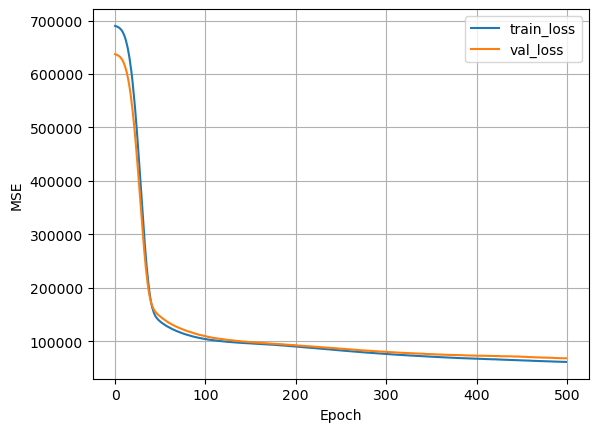

In [275]:
plot_loss(history)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  


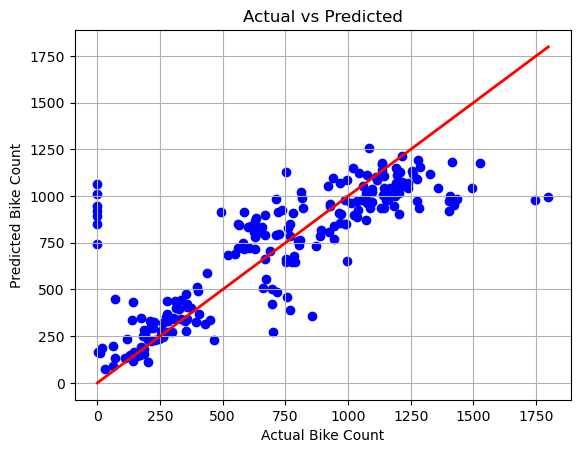

In [277]:
# Predict on training data
y_pred = nn_model.predict(x_train_all).reshape(-1)

# Plot actual vs predicted values
plt.scatter(y_train_all, y_pred, color='blue')
plt.plot(
    [y_train_all.min(), y_train_all.max()],
    [y_train_all.min(), y_train_all.max()],
    color='red',
    linewidth=2
)

plt.xlabel('Actual Bike Count')
plt.ylabel('Predicted Bike Count')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

In [279]:
# R² ≈ 0.6–0.7 → decent

# R² > 0.75 → strong

# R² < 0.4 → missing features

from sklearn.metrics import r2_score

y_pred = nn_model.predict(x_valid_all).reshape(-1)
print("R²:", r2_score(y_valid_all, y_pred))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
R²: 0.6530698136776205


In [292]:
# ---- Linear Regression predictions ----
y_pred_lr = all_reg.predict(x_test_all)

# ---- Neural Network predictions ----
y_pred_nn = nn_model.predict(x_test_all)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 


In [293]:
def MSE(y_pred,y_real):
    return (np.square(y_pred-y_real)).mean()

In [294]:
MSE(y_pred_lr,y_test_all)

89035.96258464239

In [295]:
MSE(y_pred_nn,y_test_all)

69242.81343066685

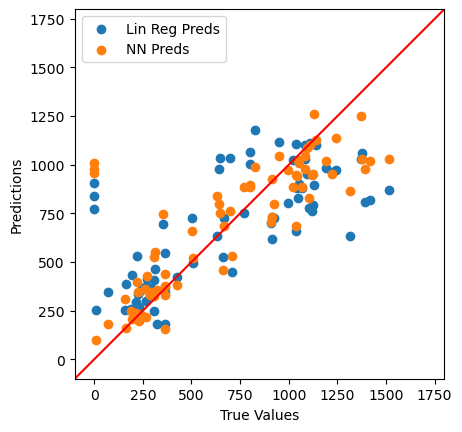

In [300]:
# Create square plot so x and y scales are identical
ax = plt.axes(aspect='equal')

# Scatter plot: Linear Regression predictions vs true values
plt.scatter(y_test_all, y_pred_lr, label='Lin Reg Preds')

# Scatter plot: Neural Network predictions vs true values
plt.scatter(y_test_all, y_pred_nn, label='NN Preds')

# Axis labels
plt.xlabel('True Values')
plt.ylabel('Predictions')

# Define axis limits
lims = [-100, 1800]
plt.xlim(lims)
plt.ylim(lims)

# Plot reference line (perfect predictions: y = x)
plt.plot(lims, lims, color='red')

# Show legend
plt.legend()

# Display plot
plt.show()